<a href="https://colab.research.google.com/github/itmo153277/JoshUpscale/blob/training/scripts/training/train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#JoshUpscale

This script is for training JoshUpscale model on Google Colab.

CPU/GPU/TPU supported.

## Setup

Code below is for confirming GPU type and instance region

In [1]:
!nvidia-smi
!apt-get install golang-go &> /dev/null
%env GOPATH=/root/go
!go get github.com/ImJasonH/gcping-1
!cd /root/go/src/github.com/ImJasonH/gcping-1 && git checkout endpoints &> /dev/null && go install
!/root/go/bin/gcping-1 -t 500ms

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

env: GOPATH=/root/go
 1.  [global]                   12.642483ms
 2.  [us-central1]              19.758655ms
 3.  [us-east4]                 158.055867ms  (1 errors)
 4.  [northamerica-northeast1]  179.669605ms
 5.  [us-east1]                 216.889746ms  (2 errors)
 6.  [us-west1]                 229.991962ms
 7.  [europe-north1]            500.36082ms   (10 errors)
 8.  [europe-west4]             500.362039ms  (10 errors)
 9.  [asia-east2]               500.36629ms   (10 errors)
10.  [asia-northeast2]          500.375593ms  (10 errors)
11.  [asia-southeast2]          500.379435ms  (10 errors)
12.  [europe-west2]             500.386354ms  (10 errors)
13.  [asia-northeast1]          500.387331ms  (10 errors)
14.  [asia-east1]               500.39003ms   (10 errors)
15.  [europe-west6]             500.394365ms  (10 errors)
16.  [europe-west3] 

Now we pull the model code and install dependencies

In [2]:
!git clone https://github.com/itmo153277/JoshUpscale.git -b training
%cd JoshUpscale/scripts/training
!pip install -r requirements.txt
!pip install tensorboard_plugin_profile cloud_tpu_profiler
%load_ext tensorboard

Cloning into 'JoshUpscale'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (257/257), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 257 (delta 128), reused 217 (delta 92), pack-reused 0
Receiving objects: 100% (257/257), 139.77 KiB | 2.59 MiB/s, done.
Resolving deltas: 100% (128/128), done.
/content/JoshUpscale/scripts/training
     |████████████████████████████████| 706kB 4.9MB/s 
     |████████████████████████████████| 389kB 10.1MB/s 
     |████████████████████████████████| 3.3MB 15.6MB/s 
     |████████████████████████████████| 26.9MB 180kB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-cp36-none-any.whl size=110728 sha256=39a2fb8a1fc62ff445516407d71b2d406e1437f392e96bc722fce22b0f605207
  Stored in directory: /root/.cache/pip/wheels/e0/fe/1c/f4e6dca9e828d4b979c04e461d7fcc5b8e7bd35f947e665b65
  Created wheel for proglog: filename=proglog-0.1.9-cp36-none-any.whl size=6149 sha256=3399e0426fa102bfc6a556424ffbcd18c83930caf9b5f32b

Lastly, we need to provide credentials for GCP

In [3]:
from google.colab import auth
auth.authenticate_user()

## Model Parameters


|Name|Type|Descrpition|
|-|:-:|-|
|`TAG`|`str`|Run tag|
|`RANDOM_SEED`|`int` or `NoneType`|Random seed. `None` will make results non-determenistic|
|`DATASET_PATH`|`str`|Path to the TFRecord dataset. Has to be on GCS for TPU|
|`BATCH_SIZE`|`int`|Batch size|
|`NUM_TEST_SET`|`int`|Number of examples for validation|
|`NUM_PLAY_SET`|`int`|Number of examples for visualistaion (from validation set)|
|`CROP_SIZE`|`int`|Image cropping size|
|`MODEL`|`str` or `NoneType`|Model preset|
|`LEARNING_RATE`|`float` or `dict` or `NoneType`|Learning rate|
|`STEPS_PER_EXECUTION`|`int` or `dict` or `NoneType`|Steps per execution|
|`CONFIG_OVERRIDE`|`dict` or `NoneType`|Config override|
|`LOGDIR`|`str`|Directory for storing TensorBoard logs. Has to be on GCS for TPU|
|`CHECKPOINTDIR`|`str`|Directory for stroing checkpoints. Has to be on local|
|`FRVSR_EPOCHS`|`int`|Epochs for FRVSR training|
|`FRVSR_STEPS`|`int`|Steps per epoch for FRVSR training|
|`GAN_EPOCHS`|`int`|Epochs for GAN training|
|`GAN_STEPS`|`int`|Steps per epoch for GAN training|

In [4]:
from datetime import datetime

TAG = datetime.now().strftime("%Y%m%d-%H%M%S")
RANDOM_SEED = 555
DATASET_PATH = "gs://able-bazaar-289411.appspot.com/new_dataset/*.tfrecord"
BATCH_SIZE = 32
NUM_TEST_SET = 32
NUM_PLAY_SET = 16
CROP_SIZE = 32
MODEL = "large"
LEARNING_RATE = 0.0005
STEPS_PER_EXECUTION = 20
CONFIG_OVERRIDE = {
    "gan_train": {
        "compile_play_fn": True,
        "compile_test_fn": True
    }
}
LOGDIR = "gs://able-bazaar-289411.appspot.com/logs"
CHECKPOINTDIR = "/content/drive/MyDrive/JoshUpscale/checkpoints"
FRVSR_EPOCHS = 10
FRVSR_STEPS = 100
GAN_EPOCHS = 10
GAN_STEPS = 100

## Initialization

### Imports

In [5]:
import os
import subprocess
import tensorflow as tf
from tensorflow import keras

import dataset
import utils
import training
import config
import train_local

### Devices

- Enable XLA
- For GPU:
  - Allow memry growth
  - Enable mixed precision
- Set random seed

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    keras.mixed_precision.experimental.set_policy("mixed_float16")
tf.config.optimizer.set_jit(True)
strategy = None
if os.environ.get("COLAB_TPU_ADDR") is not None:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="grpc://" + os.environ["COLAB_TPU_ADDR"])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
if RANDOM_SEED is not None:
    utils.set_random_seed(RANDOM_SEED)

INFO:tensorflow:Initializing the TPU system: grpc://10.114.228.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.114.228.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Datasets

- `train_ds`: Training dataset
- `val_ds`: Validation dataset
- `play_ds`: Play dataset (for visualisation)

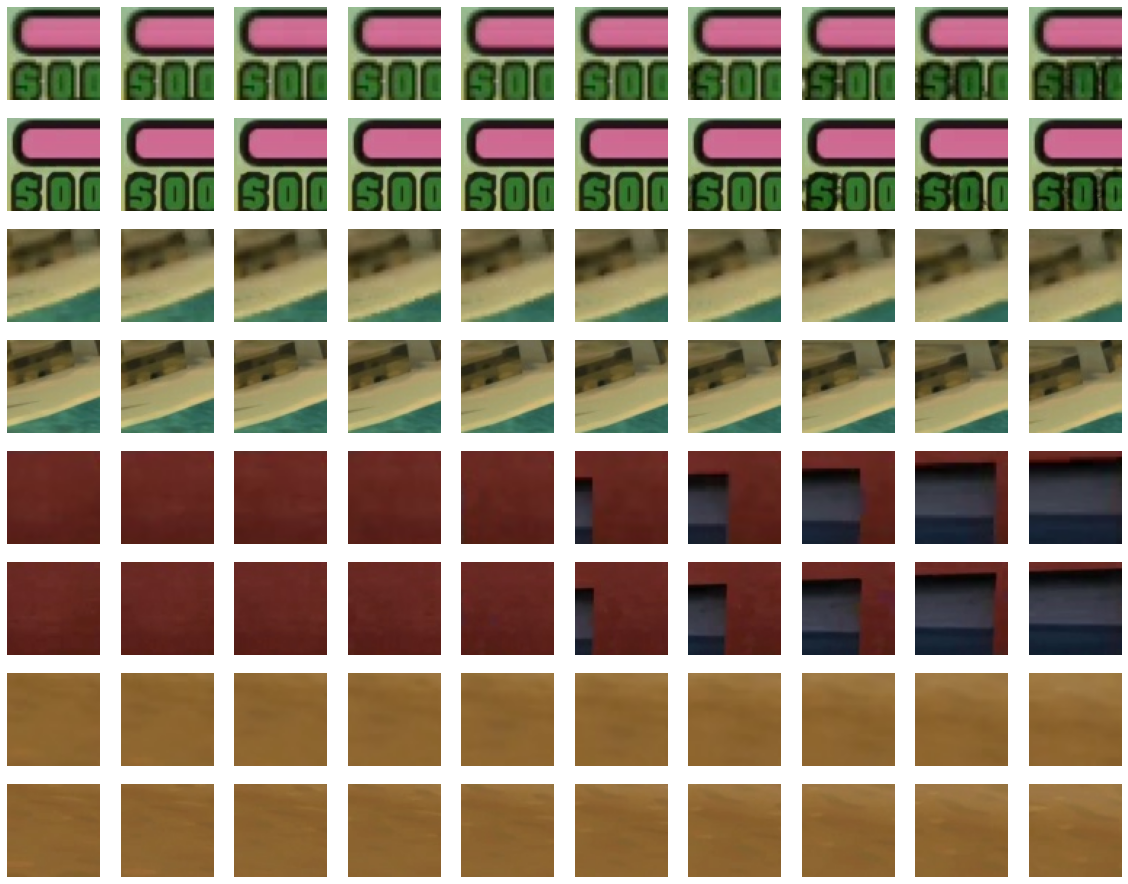

In [7]:
train_ds, val_ds, play_ds = train_local.load_datasets(
    dataset_path=DATASET_PATH,
    batch_size=BATCH_SIZE,
    num_test_set=NUM_TEST_SET,
    num_play_set=NUM_PLAY_SET,
    crop_size=CROP_SIZE
)
utils.display_data(play_ds, 4)
if strategy is not None:
    play_ds = strategy.experimental_distribute_dataset(play_ds)

### Model

In [8]:
model_config = config.get_config(
    model=MODEL,
    batch_size=BATCH_SIZE,
    crop_size=CROP_SIZE,
    learning_rate=LEARNING_RATE,
    steps_per_execution=STEPS_PER_EXECUTION,
    config_override=CONFIG_OVERRIDE
)
if strategy is None:
    model = training.Training(model_config)
else:
    model = training.DistributedTraining(model_config, strategy)
model.init()
model.full_model.summary()

Model: "full"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cur_frame (InputLayer)          [(None, None, None,  0                                            
__________________________________________________________________________________________________
last_frame (InputLayer)         [(None, None, None,  0                                            
__________________________________________________________________________________________________
flow (Functional)               (None, None, None, 2 1749634     last_frame[0][0]                 
                                                                 cur_frame[0][0]                  
__________________________________________________________________________________________________
upscale_layer_4 (UpscaleLayer)  (None, None, None, 2 0           flow[0][0]                    

## Training

### FRVSR

In [9]:
if os.environ.get("COLAB_TPU_ADDR") is not None:
    profile_proc = subprocess.Popen([
        "capture_tpu_profile",
        "--logdir={}/frvsr/{}".format(LOGDIR, TAG),
        "--service_addr={}".format(os.environ["COLAB_TPU_ADDR"])
    ])
else:
    profile_proc = None
train_local.train_frvsr(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    play_ds=play_ds,
    epochs=FRVSR_EPOCHS,
    steps=FRVSR_STEPS,
    tag=TAG,
    logdir_base=LOGDIR,
    checkpointdir_base=CHECKPOINTDIR
)
if profile_proc is not None:
    profile_proc.kill()

Epoch 1/10
100/100 [==============================] - 248s 2s/step - loss: 0.2074 - gen_outputs_loss: 0.1752 - target_warp_loss: 0.0322 - val_loss: 0.0486 - val_gen_outputs_loss: 0.0220 - val_target_warp_loss: 0.0266
Epoch 2/10
100/100 [==============================] - 19s 195ms/step - loss: 0.0462 - gen_outputs_loss: 0.0137 - target_warp_loss: 0.0326 - val_loss: 0.0394 - val_gen_outputs_loss: 0.0110 - val_target_warp_loss: 0.0284
Epoch 3/10
100/100 [==============================] - 17s 172ms/step - loss: 0.0406 - gen_outputs_loss: 0.0068 - target_warp_loss: 0.0339 - val_loss: 0.0378 - val_gen_outputs_loss: 0.0087 - val_target_warp_loss: 0.0292
Epoch 4/10
100/100 [==============================] - 17s 173ms/step - loss: 0.0358 - gen_outputs_loss: 0.0047 - target_warp_loss: 0.0311 - val_loss: 0.0329 - val_gen_outputs_loss: 0.0038 - val_target_warp_loss: 0.0291
Epoch 5/10
100/100 [==============================] - 17s 174ms/step - loss: 0.0325 - gen_outputs_loss: 0.0037 - target_warp_l

### GAN

In [10]:
if os.environ.get("COLAB_TPU_ADDR") is not None:
    profile_proc = subprocess.Popen([
        "capture_tpu_profile",
        "--logdir={}/gan/{}".format(LOGDIR, TAG),
        "--service_addr={}".format(os.environ["COLAB_TPU_ADDR"])
    ])
else:
    profile_proc = None
train_local.train_gan(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    play_ds=play_ds,
    epochs=GAN_EPOCHS,
    steps=GAN_STEPS,
    tag=TAG,
    logdir_base=LOGDIR,
    checkpointdir_base=CHECKPOINTDIR
)
if profile_proc is not None:
    profile_proc.kill()

Epoch 1/10
100/100 [===================================] 228s, 2.28s/step, gen_loss=0.0209, fnet_loss=0.0341, discr_loss=1.03
gen_loss 0.0024934085 fnet_loss 0.005899299 discr_loss 0.13811833 content_loss 0.0011465111 warp_loss 0.0034092434
Epoch 2/10
100/100 [===================================] 50s, 2.02step/s, gen_loss=0.0197, fnet_loss=0.0424, discr_loss=1.3
gen_loss 0.0030464274 fnet_loss 0.006315059 discr_loss 0.102759376 content_loss 0.0015503574 warp_loss 0.0032720275
Epoch 3/10
100/100 [===================================] 50s, 2.02step/s, gen_loss=0.0179, fnet_loss=0.0363, discr_loss=0.843
gen_loss 0.0021582115 fnet_loss 0.005294567 discr_loss 0.10909653 content_loss 0.0009070615 warp_loss 0.0031392698
Epoch 4/10
100/100 [===================================] 50s, 2.02step/s, gen_loss=0.0157, fnet_loss=0.0412, discr_loss=0.891
gen_loss 0.0017777316 fnet_loss 0.0047533545 discr_loss 0.1127008 content_loss 0.0007363518 warp_loss 0.0029781437
Epoch 5/10
100/100 [=================